# Creating Multimodal RAG using Amazon Bedrock Knowledge Bases

Amazon Bedrock Knowledge Bases leverage Retrieval Augmented Generation (RAG), a technique that harnesses customer data stores to enhance responses generated by foundation models. Knowledge bases allow agents to access existing customer data repositories without extensive administrator overhead. To connect a knowledge base to your data, you specify an S3 bucket as the data source. By employing knowledge bases, applications gain enriched contextual information, streamlining development through a fully-managed RAG solution.

## Use Case

We are a Customer Support Agent for AnyCompany Telecom who helps resolve customer issues. Our AI assistant uses RAG to retrieve relevant information and provide quick resolutions to connectivity issues, product questions, and more.

We will load multimodal documents (text, charts, and images) into a Knowledge Base and query them using the RetrieveAndGenerate API.

![images/mm-rag.png](../images/mm-rag.png)


### Setup

In [ ]:
%pip install --upgrade -r requirements.txt -q

In [ ]:
#Install AWS and API tools
import boto3
from botocore.exceptions import ClientError

# Data handling tools
import json
import base64

# Display and formatting tools
from IPython.display import display, Image
import pprint

# System tools
import os

# Utilities
import random
import time
from retrying import retry

boto3_session = boto3.session.Session()
pp = pprint.PrettyPrinter(indent=2)

In [ ]:
# Retrieve region_name and MODEL_ID persisted by notebook 1
%store -r region_name
%store -r MODEL_ID
print(f"Current AWS Region: {region_name}")
print(f"Model ID: {MODEL_ID}")

In [ ]:
account_id = boto3.client("sts").get_caller_identity().get("Account")
s3_client = boto3.client("s3")

bucket_name = f"mmu-workshop-{account_id}"
tmp_bucket_name = f"mmu-workshop-tmp-{account_id}"

def ensure_bucket(name):
    """Find an existing bucket matching the prefix, or create one."""
    r = s3_client.list_buckets(Prefix=name)
    for b in r.get("Buckets", []):
        if b["Name"].startswith(name):
            return b["Name"]
    # Bucket doesn't exist — create it
    if region_name == "us-east-1":
        s3_client.create_bucket(Bucket=name)
    else:
        s3_client.create_bucket(
            Bucket=name,
            CreateBucketConfiguration={"LocationConstraint": region_name}
        )
    print(f"Created bucket: {name}")
    return name

bucket_name = ensure_bucket(bucket_name)
s3_client.put_object(Bucket=bucket_name, Key="mm-data/")
print(f"Successfully created mm-data/ folder in {bucket_name}")
print(f"S3 URI for Data Source: s3://{bucket_name}/mm-data/")

tmp_bucket_name = ensure_bucket(tmp_bucket_name)
print(f"S3 URI for Multimodal Storage: s3://{tmp_bucket_name}")




### 1. Create the KB

**Step 1:** Navigate to the [Amazon Bedrock > Knowledge base > Create knowledge](https://us-east-1.console.aws.amazon.com/bedrock/home?region=us-east-1#/knowledge-bases/create-knowledge-base) base console as shown:

![images/kb/kb-home.png](../images/kb/kb-home.png)

**Step 2**: Next, select **Create Knowledge Base > Knowledge Base with vector store**.

**Step 3**: Provide knowledge base details:

- **KB Name**: `knowledge-base-customer-support` (add a relevant description)
- **IAM Role**: Let the KB create an IAM role with all needed permissions
- **Data Source**: Choose S3 as the data source (we will upload documents to it later in this notebook)

![images/kb/kb-setup.png](../images/kb/kb-setup.png)

**Step 4**: Configure the data source:

- **S3 URI**: Use `s3://mmu-workshop-*****/mm-data` (the bucket and sub-folder created above)
- **Parsing Strategy**: Select **Foundation models as a parser**, then choose **Amazon Nova 2 Lite** as the model

Nova 2 Lite will parse the multimodal content and summarize images before passing them to the generator model.

![images/kb/kb-config-1.png](../images/kb/kb-config-1.png)

![images/kb/kb-config-2.png](../images/kb/kb-config-2.png)

<div class="alert alert-block alert-info">
<b>S3 URI for Data Source</b><br>
Use the bucket created above for your multimodal PDF files:<br>
<code>s3://mmu-workshop-********/mm-data</code>
<br><br>
<b>S3 URI for Multimodal Storage</b><br>
A separate bucket stores parsed images extracted during ingestion:<br>
<code>s3://mmu-workshop-tmp-********</code>
</div>

**Step 5**: Select embedding model and configure vector store:

- **Embedding Model**: Select **Amazon Nova Multimodal Embeddings Model**
- **Vector Database**: Select **S3 Vectors**
- **Multimodal Storage Destination**: Select the `mmu-workshop-tmp-******` bucket

![images/kb/storage-config.png](../images/kb/storage-config.png)

**Step 6**: Review and create the Knowledge Base.

Click **Submit**. Creation typically takes 4-5 minutes. You will see a success message when complete:

![images/kb/kb_successmsg.png](../images/kb/kb_successmsg.png)


### This overall process takes roughly 10 minutes.

### 2. Key Information

Once the Knowledge Base is created, note down the following values and enter them in the cell below.

<div class="alert alert-block alert-info">
<b>Note:</b> Copy the Knowledge Base Name, ID, Data Source ID, and IAM Role Name from the console.
</div>

![images/kb/kb-id.png](../images/kb/kb-id.png)

![images/kb/data-source-id.png](../images/kb/data-source-id.png)

In [ ]:
## ⚠️ ⚠️ replace below values with the created Knowledge Base and Data Source
kb_name = "" # add your knowledge base name here
kb_id = ""   # add your knowledge base id here
kb_iam_role_name = ""    #add your knowledge base iam role name here
ds_id = ""  # add your data source id here

Verify that all resources are created correctly and ready to be used:

In [ ]:
bedrock_agent_client = boto3_session.client("bedrock-agent")
bedrock_agent_runtime_client = boto3.client("bedrock-agent-runtime")

get_kb_response = bedrock_agent_client.get_knowledge_base(knowledgeBaseId=kb_id)

get_ds_response = bedrock_agent_client.get_data_source(
    knowledgeBaseId=kb_id, dataSourceId=ds_id
)

%store kb_name
%store kb_id
%store ds_id
%store account_id
%store bucket_name

### 3. Ingest the customer support information files into the S3 location 

### S3 Buckets Used

1. **Data Source Bucket** (`mmu-workshop-<ACCOUNT_ID>`): Input for the Knowledge Base data source. Documents are uploaded to the `mm-data/` partition.

2. **Multimodal Storage Bucket** (`mmu-workshop-tmp-<ACCOUNT_ID>`): Stores extracted images from multimodal documents, referenced when answering image-related questions.

**Note**: We sync to the `mm-data/` partition. If you use a different path, update accordingly.

In [ ]:
# Upload data to S3 to the bucket that was configured as a data source to the Knowledge Base

s3_client = boto3.client("s3")


def interactive_sleep(seconds: int):
    dots = ""
    for i in range(seconds):
        dots += "."
        print(dots, end="\r")
        time.sleep(1)


def uploadDirectory(path, bucket_name, s3_path):
    for root, dirs, files in os.walk(path):
        for file in files:
            local_file_path = os.path.join(root, file)
            s3_key = os.path.join(s3_path, os.path.relpath(local_file_path, path))
            # Upload the file with the new S3 key
            s3_client.upload_file(local_file_path, bucket_name, s3_key)


uploadDirectory("mm-rag-docs", bucket_name, "mm-data")

### 4. Sync the KB Data Source

You can also do this from the console by clicking **Sync Data Source**.

![images/kb/kb_sync.png](../images/kb/kb_sync.png)

This may take 5-7 minutes to complete.

In [ ]:
interactive_sleep(30)
ingest_jobs = []

# Start an ingestion job
try:
    start_job_response = bedrock_agent_client.start_ingestion_job(
        knowledgeBaseId=kb_id, dataSourceId=ds_id
    )
    job = start_job_response["ingestionJob"]
    job_id = job["ingestionJobId"]
    print(f"Ingestion job started successfully. {job_id=}")

    while job["status"] not in ["COMPLETE", "FAILED", "STOPPED"]:
        get_job_response = bedrock_agent_client.get_ingestion_job(
            knowledgeBaseId=kb_id, dataSourceId=ds_id, ingestionJobId=job_id
        )
        job = get_job_response["ingestionJob"]
    pp.pprint(job)
    interactive_sleep(40)
    ingest_jobs.append(job)
except Exception as e:
    print("Failed to start ingestion job!")
    print(e)

### 5. Update the IAM Policy to include Amazon Nova as generator

In [ ]:
def attach_policy_json_to_role(role_name, policy_name, policy_json):
    """
    Attaches a policy JSON directly to an IAM role.

    :param role_name: The name of the IAM role
    :param policy_name: The name to give the new policy
    :param policy_json: The policy document as a JSON string or dictionary
    :return: True if successful, False otherwise
    """
    try:
        # Create an IAM client
        iam_client = boto3.client("iam")

        # Ensure policy_json is a string
        if isinstance(policy_json, dict):
            policy_json = json.dumps(policy_json)

        # Create the policy
        response = iam_client.create_policy(
            PolicyName=policy_name, PolicyDocument=policy_json
        )

        # Get the ARN of the newly created policy
        policy_arn = response["Policy"]["Arn"]

        # Attach the policy to the role
        iam_client.attach_role_policy(RoleName=role_name, PolicyArn=policy_arn)

        print(
            f"Successfully created policy {policy_name} and attached it to role {role_name}"
        )
        return True

    except Exception as e:
        print(f"Error attaching policy JSON to role: {str(e)}")
        return False


# Example usage
policy_name = "NovaProModelPolicy"
policy_json = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "BedrockInvokeModelStatement",
            "Effect": "Allow",
            "Action": ["bedrock:*"],
            "Resource": [
                f"arn:aws:bedrock:us-east-1::foundation-model/{MODEL_ID.removeprefix('us.')}",
                f"arn:aws:bedrock:us-west-2::foundation-model/{MODEL_ID.removeprefix('us.')}",
                f"arn:aws:bedrock:us-east-1:{account_id}:inference-profile/{MODEL_ID}",
            ],
        }
    ],
}

attach_policy_json_to_role(kb_iam_role_name, policy_name, policy_json)

### 6. Test the Knowledge Base

### Using RetrieveAndGenerate API

The `RetrieveAndGenerate` API converts queries into embeddings, searches the knowledge base, augments the foundation model prompt with the search results, and returns the generated response. It also manages short-term memory for multi-turn conversations.

The response includes the generated text, source attribution, and retrieved text chunks.

In [ ]:
import io
import s3fs
import ipywidgets as widgets
from PIL import Image as PILImage


def ask_bedrock_llm_with_knowledge_base(query: str, model_arn: str, kb_id: str) -> str:
    response = bedrock_agent_runtime_client.retrieve_and_generate(
        input={"text": query},
        retrieveAndGenerateConfiguration={
            "type": "KNOWLEDGE_BASE",
            "knowledgeBaseConfiguration": {
                "knowledgeBaseId": kb_id,
                "modelArn": model_arn,
                "retrievalConfiguration": {
                    "vectorSearchConfiguration": {
                        "numberOfResults": 5
                    }
                },
            },
        },
    )
    return response


fs = s3fs.S3FileSystem()


## Function to print retrieved response
def print_response(response):
    # Response structure: ['ResponseMetadata', 'citations', 'output', 'sessionId']
    generated_text = response["output"]["text"]
    ref_ref_location_lst = []
    ref_ref_location_lst.append({"generated_text": generated_text})
    for num, chunk in enumerate(response["citations"]):
        ref_locations = []
        for i, ref in enumerate(chunk["retrievedReferences"]):
            # Source URI is in location.s3Location.uri
            s3_uri = ref.get("location", {}).get("s3Location", {}).get("uri", "")
            data_dict = {
                "ref_location": ref["location"],
                "ref_source_uri": s3_uri,
            }
            metadata = ref.get("metadata", {})
            if "x-amz-bedrock-kb-byte-content-source" in metadata:
                data_dict["ref_image"] = metadata[
                    "x-amz-bedrock-kb-byte-content-source"
                ]
            ref_locations.append(data_dict)
        ref_ref_location_lst.append({"chunk_details": ref_locations})
    return ref_ref_location_lst


def create_tree_widget(data, s3=None):
    s3 = s3 or s3fs.S3FileSystem(anon=False)
    main_accordion = widgets.Accordion()

    for i, item in enumerate(data):
        subchildren = []

        # Always add Generated Text first
        if "generated_text" in item:
            text_widget = widgets.Textarea(
                value=str(item["generated_text"]),
                disabled=True,
                layout=widgets.Layout(width="500px", height="200px"),
            )
            subchildren.append(text_widget)

        # Then add Chunk Details
        if "chunk_details" in item:
            chunk_accordion = widgets.Accordion()
            chunk_children = []

            for chunk in item["chunk_details"]:
                chunk_subchildren = []

                for key, value in chunk.items():
                    if (
                        key == "ref_image"
                        and isinstance(value, str)
                        and value.startswith("s3://")
                    ):
                        try:
                            with s3.open(value, "rb") as f:
                                img = PILImage.open(f).resize((400, 400))
                                img_byte_arr = io.BytesIO()
                                img.save(img_byte_arr, format="PNG")
                                img_widget = widgets.Image(
                                    value=img_byte_arr.getvalue(),
                                    format="png",
                                    width=400,
                                    height=400,
                                )
                            chunk_subchildren.append(img_widget)
                        except Exception as e:
                            chunk_subchildren.append(widgets.Label(f"Image Error: {e}"))
                    else:
                        chunk_subchildren.append(
                            widgets.Label(f"{key}: {json.dumps(value)}")
                        )

                chunk_item_accordion = widgets.Accordion(
                    children=tuple(chunk_subchildren)
                )
                for k, child in enumerate(chunk_subchildren):
                    chunk_item_accordion.set_title(k, list(chunk.keys())[k])

                chunk_children.append(chunk_item_accordion)

            chunk_accordion = widgets.Accordion(children=tuple(chunk_children))
            for j, child in enumerate(chunk_children):
                chunk_accordion.set_title(j, f"Chunk {j+1}")

            subchildren.append(chunk_accordion)

        # Create item accordion with correct titles
        item_accordion = widgets.Accordion(children=tuple(subchildren))
        item_accordion.set_title(0, "Generated Text")
        if len(subchildren) > 1:
            item_accordion.set_title(1, "Chunk Details")

        main_accordion.children += (item_accordion,)
        main_accordion.set_title(i, f"Item {i}")

    return main_accordion

### Testing with API

In [11]:
query = "My phone shows -82 dBm signal strength. Is this good enough for streaming video?"
model_arn = f"arn:aws:bedrock:{region_name}:{account_id}:inference-profile/{MODEL_ID}"

response = ask_bedrock_llm_with_knowledge_base(query, model_arn, kb_id)
response_data = print_response(response)
tree_widget = create_tree_widget(response_data)
display(tree_widget)

Accordion(children=(Accordion(children=(Textarea(value='Based on the signal quality reference, a -82 dBm signa…

In [12]:
query = "My installer mounted my router high up on the wall - seems weird. Is this actually better?"

response = ask_bedrock_llm_with_knowledge_base(query, model_arn, kb_id)
response_data = print_response(response)
tree_widget = create_tree_widget(response_data)
display(tree_widget)

Accordion(children=(Accordion(children=(Textarea(value="Mounting your router high up on the wall can be a good…

Now let's test a query that includes an image. We adjust our function to include an image in the input payload.

In [13]:

#define function to encode images
def get_base64_encoded_value(media_path):
    """Convert media file to base64 encoded string.
    
    Args:
        media_path (str): Path to the media file
        
    Returns:
        str: Base64 encoded string
    """
    with open(media_path, "rb") as media_file:
        binary_data = media_file.read()
        base_64_encoded_data = base64.b64encode(binary_data)
        base64_string = base_64_encoded_data.decode("utf-8")
        return base64_string

#define function to call Bedrock including an image in the input
def ask_bedrock_llm_with_knowledge_base_mm(query: str, image_path: str, model_arn: str, kb_id: str) -> str:
    response = bedrock_agent_runtime_client.retrieve_and_generate(
        input={"text": query},
        retrieveAndGenerateConfiguration={
            "type": "KNOWLEDGE_BASE",
            "knowledgeBaseConfiguration": {
                "knowledgeBaseId": kb_id,
                "modelArn": model_arn,
            },
        },
    )

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "image": {
                        "format": "png",
                        "source": {"bytes": get_base64_encoded_value(image_path)}
                    }
                },
                {"text": query}
            ]
        }
    ]
    return response


Router setup


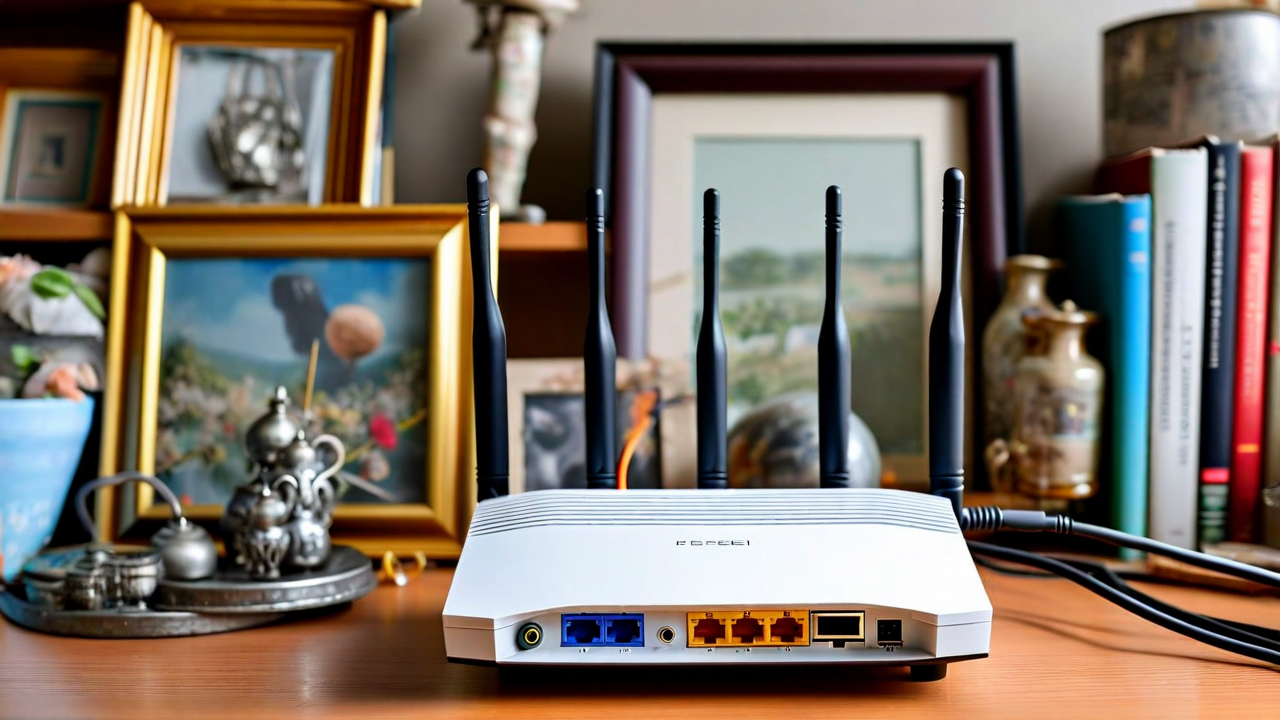

In [14]:
query = "This is the best I can do for my router setup given my skills. Can this work?"

# Path to the damage photo
image_path = "images/wifi-router.png"

# Display the image
print("Router setup")
display(Image(filename=image_path, width=600))  # Adjust width as needed for clear visibility


In [15]:
response = ask_bedrock_llm_with_knowledge_base_mm(query, image_path, model_arn, kb_id)
response_data = print_response(response)
tree_widget = create_tree_widget(response_data)
display(tree_widget)

Accordion(children=(Accordion(children=(Textarea(value="The setup shown in the image appears to be a **poor pl…

### Testing in the Bedrock Knowledge Base Console

- Go to the [Knowledge Base Console](https://us-east-1.console.aws.amazon.com/bedrock/home?region=us-east-1#/knowledge-bases)
- Click on the Knowledge Base you created
- Click **Test Knowledge Base**
  ![](../images/kb/kb-test-knowledge-base.png)
- In the console, test with the same queries used above:
  - Configuration: select **Retrieval and response generation: data sources and model**
  - Select Nova 2 Lite as the generation model
  ![](../images/kb/kb-console-testing.png)


## Conclusion

In this lab, we explored how to build a multimodal Retrieval Augmented Generation (RAG) system using Amazon Bedrock Knowledge Bases. We created a customer support assistant that can:

1. **Process multimodal documents** - Our system ingested documents containing not just text, but also tables and images
2. **Leverage Amazon Nova models** - We used Nova Lite as a parser to extract and understand visual content and Nova Pro as the generator model
3. **Build a complete multimodal RAG pipeline** - From creating the knowledge base to configuring the vector store to testing with different query types

These capabilities are essential for creating AI assistants that can truly understand and reason about the rich multimodal world of business information.